# _import modules:_

In [20]:
# enable In-Line MatPlotLib
%matplotlib inline

In [39]:
# import:
from __future__ import division, print_function
from matplotlib.pyplot import figure, legend, plot, title
from multiprocessing import cpu_count
from numpy import exp, float, int, linspace, log, nan, sqrt
from os import system
from os.path import join
from pandas import Categorical, read_csv
from random import seed
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame

In [24]:
RANDOM_SEED = 99
seed(RANDOM_SEED)

In [41]:
from __future__ import division
from numpy import log, sqrt
from pandas import DataFrame


def mse(y_hat, y):
    return ((y_hat - y) ** 2).mean()


def rmse(y_hat, y):
    return sqrt(mse(y_hat, y))


def bin_class_dev(p_hat, y, pos_cat=None, tiny=1e-32):
    if hasattr(y, 'cat'):
        y_bool = y == pos_cat
    else:
        y_bool = y.astype(bool)
    return - 2 * (y_bool * log(p_hat + tiny) + (1 - y_bool) * log(1 - p_hat + tiny)).mean()


def bin_classif_eval_hard_pred(hard_predictions, actuals, pos_cat=None):

    if hasattr(hard_predictions, 'cat'):
        hard_predictions_bool = hard_predictions == pos_cat
    else:
        hard_predictions_bool = hard_predictions.astype(bool)

    if hasattr(actuals, 'cat'):
        actuals_bool = actuals == pos_cat
    else:
        actuals_bool = actuals.astype(bool)

    opposite_hard_predictions_bool = ~ hard_predictions_bool
    opposite_actuals_bool = ~ actuals_bool

    nb_samples = len(actuals)
    nb_pos = sum(actuals_bool)
    nb_neg = sum(opposite_actuals_bool)
    nb_pred_pos = sum(hard_predictions_bool)
    nb_pred_neg = sum(opposite_hard_predictions_bool)
    nb_true_pos = sum(hard_predictions_bool & actuals_bool)
    nb_true_neg = sum(opposite_hard_predictions_bool & opposite_actuals_bool)
    nb_false_pos = sum(hard_predictions_bool & opposite_actuals_bool)
    nb_false_neg = sum(opposite_hard_predictions_bool & actuals_bool)

    accuracy = (nb_true_pos + nb_true_neg) / nb_samples
    recall = nb_true_pos / nb_pos
    specificity = nb_true_neg / nb_neg
    precision = nb_true_pos / nb_pred_pos
    f1_score = (2 * precision * recall) / (precision + recall)

    return dict(
        accuracy=accuracy,
        recall=recall,
        specificity=specificity,
        precision=precision,
        f1_score=f1_score)


def bin_classif_eval(predictions, actuals, pos_cat=None, thresholds=.5):

    if hasattr(predictions, 'cat') or (predictions.dtype in ('bool', 'int')):
        return bin_classif_eval_hard_pred(predictions, actuals, pos_cat=pos_cat)

    if isinstance(thresholds, (float, int)):
        hard_predictions = predictions >= thresholds
        metrics = bin_classif_eval_hard_pred(hard_predictions, actuals, pos_cat=pos_cat)
        metrics['deviance'] = bin_class_dev(predictions, actuals, pos_cat=pos_cat)
    else:
        metrics = DataFrame(dict(threshold=thresholds))
        metrics['accuracy'] = 0.
        metrics['recall'] = 0.
        metrics['specificity'] = 0.
        metrics['precision'] = 0.
        metrics['f1_score'] = 0.
        metrics['deviance'] = 0.
        for i in range(len(thresholds)):
            m = bin_classif_eval(predictions, actuals, pos_cat=pos_cat, thresholds=thresholds[i])
            metrics.ix[i, 'accuracy'] = m['accuracy']
            metrics.ix[i, 'recall'] = m['recall']
            metrics.ix[i, 'specificity'] = m['specificity']
            metrics.ix[i, 'precision'] = m['precision']
            metrics.ix[i, 'f1_score'] = m['f1_score']
            metrics.ix[i, 'deviance'] = m['deviance']

    return metrics


from __future__ import print_function
from pprint import pprint
from sys import stdout


def printflush(*args, **kwargs):
    print(*args, **kwargs)
    stdout.flush()


# import Tabloid Marketing data set

In [28]:
# read Credit Scoring data into data frame
y_var_name = 'purchase'
X_var_names = [
    'nTab',
    'moCbook',
    'iRecMer1',
    'llDol']
column_classes = dict(
    purchase=int,
    nTab=float,
    moCbook=float,
    iRecMer1=float,
    llDol=float)

data_repo_raw_path = 'https://raw.githubusercontent.com/ChicagoBoothML/MLClassData/master/Tabloid/Tabloid_train.csv'
tabloid_train = read_csv(data_repo_raw_path,
    dtype=column_classes)

tabloid_train.purchase = Categorical(tabloid_train.purchase)

nb_train_samples = len(tabloid_train)

tabloid_train

,purchase,nTab,moCbook,iRecMer1,llDol
0,0,0.0,50.000000,0.019608,-2.302585
1,1,4.0,19.218130,0.049461,3.893452
2,0,1.0,50.000000,0.119167,-2.302585
3,0,1.0,50.000000,0.019608,-2.302585
4,0,0.0,50.000000,0.019608,-2.302585
5,0,10.0,50.000000,0.105900,5.153465
6,0,0.0,50.000000,0.028096,-2.302585
7,0,0.0,50.000000,0.019608,-2.302585
8,0,0.0,50.000000,0.373772,-2.302585
9,0,0.0,50.000000,0.019608,-2.302585


Just to sanity-check, the classes of the variables are:

In [29]:
#cs.apply(lambda col: col.dtype)

for col_name in tabloid_train:
    printflush('%s: %s' %(col_name, tabloid_train[col_name].dtype))

purchase: category
nTab: float64
moCbook: float64
iRecMer1: float64
llDol: float64


The incidence of responsiveness to marketing in the Training set is:

In [30]:
sum(tabloid_train.purchase) / nb_train_samples

0.0258

Note that this creates a "**skewed classes**" problem: one of the classes of cases (here the "delinquent" class) is significantly rarer than the other.

_(**note**: in more extreme cases where one class is much, much rarer than the other to the order of 1000 or 10,000 times, our model fitting procedures would need to be tweaked; but this case is not so extreme)_

The proportions of missing data points per column in the Training set are as follows:

In [31]:
tabloid_train.isnull().sum() / len(tabloid_train)

purchase    0.0
nTab        0.0
moCbook     0.0
iRecMer1    0.0
llDol       0.0
dtype: float64

Let's now split a bit of data from the Training set as a Validation set for the purpose of estimating OOS performance metrics:

In [32]:
tabloid_train, tabloid_valid = train_test_split(
    tabloid_train,
    train_size=2. / 3.,
    random_state=RANDOM_SEED)

Just to sanity-check that the data sets have been split representatively: the delinquency incidences in the Training and Validation sets are:

In [33]:
for data_set in (tabloid_train, tabloid_valid):
    printflush('%i obs: %f responsive' %(len(data_set), sum(data_set.purchase) / len(data_set)))

6666 obs: 0.025503 responsive
3334 obs: 0.026395 responsive


# Classification Models

Let's train 3 types of classification models: a Random Forest, a Boosted Trees model and a Logistic Regression.

In [34]:
B = 1000

rf_model = RandomForestClassifier(
    n_estimators=B,
    criterion='entropy',
    max_depth=None,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
    min_samples_split=60,
    min_samples_leaf=30,
    min_weight_fraction_leaf=0.0,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    bootstrap=True,
    oob_score=True,   # estimate Out-of-Bag Cross Entropy
    n_jobs=cpu_count() - 2,   # paralellize over all CPU cores but 2
    class_weight=None,    # our classes are skewed, but but too skewed
    random_state=RANDOM_SEED,
    verbose=0,
    warm_start=False)

rf_model.fit(X=tabloid_train[X_var_names], y=tabloid_train.purchase)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=30,
            min_samples_split=60, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=2, oob_score=True, random_state=99,
            verbose=0, warm_start=False)

In [35]:
B = 1000

boost_model = GradientBoostingClassifier(
    n_estimators=B,
    loss='deviance',   # a.k.a Cross Entropy in Classification
    learning_rate=.01,   # shrinkage parameter
    subsample=1.,
    min_samples_split=120,
    min_samples_leaf=60,
    min_weight_fraction_leaf=0.0,
    max_depth=10,   # maximum tree depth / number of levels of interaction
    init=None,
    random_state=RANDOM_SEED,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    verbose=0,
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    warm_start=False)

boost_model.fit(X=tabloid_train[X_var_names], y=tabloid_train.purchase)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=60,
              min_samples_split=120, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=99,
              subsample=1.0, verbose=0, warm_start=False)

In [36]:
log_reg_model = LogisticRegression(
    penalty='l2',
    dual=False,
    tol=0.0001,
    C=1e3,   # large C so as NOT to regularize too strongly
    fit_intercept=True,
    intercept_scaling=1.,
    class_weight=None,
    random_state=RANDOM_SEED,
    solver='lbfgs',
    max_iter=100,
    multi_class='multinomial',
    verbose=0)

X_standard_scaler = StandardScaler()
X_standard_scaler.fit(tabloid_train[X_var_names])
log_reg_model.fit(
    X=X_standard_scaler.transform(tabloid_train[X_var_names]),
    y=tabloid_train.purchase)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1.0, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=99, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

We'll now evaluate the OOS performances of these 3 models on the Validation set to select a model we think is best:

In [37]:
low_prob = 1e-6
high_prob = 1 - low_prob
log_low_prob = log(low_prob)
log_high_prob = log(high_prob)
log_prob_thresholds = linspace(start=log_low_prob, stop=log_high_prob, num=100)
prob_thresholds = exp(log_prob_thresholds)

In [42]:
rf_pred_probs = rf_model.predict_proba(X=tabloid_valid[X_var_names])
rf_oos_performance = bin_classif_eval(
    rf_pred_probs[:, 1], tabloid_valid.purchase,
    pos_cat=1, thresholds=prob_thresholds)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in long_scalars


In [43]:
boost_pred_probs = boost_model.predict_proba(X=tabloid_valid[X_var_names])
boost_oos_performance = bin_classif_eval(
    boost_pred_probs[:, 1], tabloid_valid.purchase,
    pos_cat=1, thresholds=prob_thresholds)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in long_scalars


In [44]:
log_reg_pred_probs = log_reg_model.predict_proba(
    X=X_standard_scaler.transform(tabloid_valid[X_var_names]))
log_reg_oos_performance = bin_classif_eval(
    log_reg_pred_probs[:, 1], tabloid_valid.purchase,
    pos_cat=1, thresholds=prob_thresholds)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in long_scalars


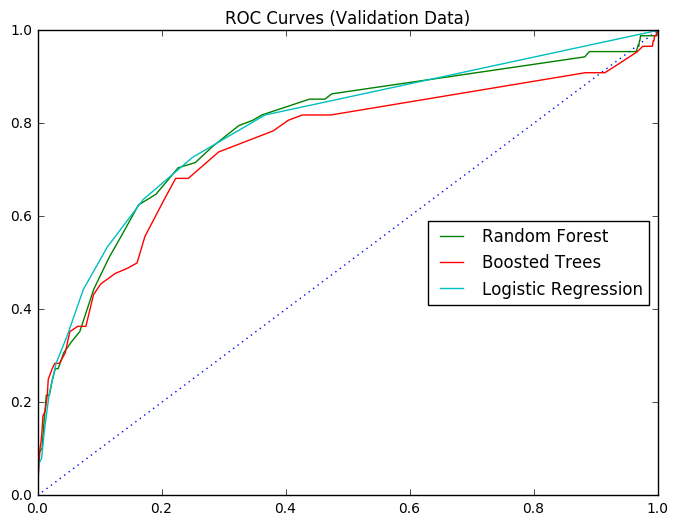

In [45]:
figure(figsize=(8, 6))
plot(
    [0, 1], [0, 1],
    linestyle='dotted')
plot(
    1 - rf_oos_performance.specificity,
    rf_oos_performance.recall,
    label='Random Forest')
plot(
    1 - boost_oos_performance.specificity,
    boost_oos_performance.recall,
    label='Boosted Trees')
plot(
    1 - log_reg_oos_performance.specificity,
    log_reg_oos_performance.recall,
    label='Logistic Regression')
title('ROC Curves (Validation Data)')
legend(loc='right')

We see that with suitable data, Logistic Regression is right up there with Random Forest and Boosted Trees in terms of OOS performance! Let's choose the Logistic Regression model for evaluation on the Test set.

We now need to pick a decision threshold for the Boosted Trees model. If we are to be really rigorous, we'll need to inject some business knowledge, e.g. balancing the costs opportunity costs of missing out lucrative customers and the costs of targeted marketing. Here, to make life simple, we'll pick a subjective threshold that enables us to anticipate **80%** of the responsive cases:

In [46]:
recall_threshold = .8
idx = next(i for i in range(100) if log_reg_oos_performance.recall[i] <= recall_threshold) - 1
selected_prob_threshold = prob_thresholds[idx]
selected_prob_threshold

0.10722663230387419

The OOS performance of the Logistic Regression algorithm at this threshold is as follows:

In [47]:
log_reg_oos_performance.iloc[idx, :]

threshold      0.107227
accuracy       0.637972
recall         0.818182
specificity    0.633087
precision      0.057007
f1_score       0.106588
deviance       0.346598
Name: 83, dtype: float64

Note that there is trade-off: the precision of the model at this sensitivity threshold is rather low, meaning that there'll be many false positives, i.e. we may be spamming and annoying lots of people.

# Test Performance of Selected Model

In [48]:
tabloid_test = read_csv('https://raw.githubusercontent.com/ChicagoBoothML/MLClassData/master/Tabloid/Tabloid_train.csv',
    dtype=column_classes)

tabloid_test.purchase = Categorical(tabloid_test.purchase)

The expected performance of the model on the Test set at the decision threshold determined above is as follows:

In [49]:
log_reg_pred_probs = log_reg_model.predict_proba(
    X=X_standard_scaler.transform(tabloid_test[X_var_names]))
log_reg_oos_performance = bin_classif_eval(
    log_reg_pred_probs[:, 1], tabloid_test.purchase,
    pos_cat=1, thresholds=selected_prob_threshold)
log_reg_oos_performance

{'accuracy': 0.64159999999999995,
 'deviance': 0.34496412262491771,
 'f1_score': 0.10355177588794398,
 'precision': 0.055347593582887704,
 'recall': 0.80232558139534882,
 'specificity': 0.63734346130158082}

We can see that the Test performance is broadly similar to what we've estimated from the Validation set. The selected model works as expected: we'll get responsiveness from >70% of the targeted customers, but our reputation as a spamming organization will also be reinforced...